# Problem Description

This project implements Reinforcement Learning (RL) for the Recycling Robot problem (Example 3.3 in the textbook).

Goal:

- Use the Temporal Difference (TD) algorithm so the robot learns to maximize the total reward over time.

Key choices and requirements:

- Select values for the probabilities alpha (α) and beta (β), and for the rewards r_search and r_wait, ensuring r_search > r_wait.
- Use TD learning to update value estimates and derive a policy that maximizes accumulated reward.
- Define a learning period (epoch) of, for example, 1000 steps. After each epoch, save the total reward accumulated during that epoch to a file named `rewards.txt`.
- Train for multiple epochs and plot the accumulated total reward over epochs (Matplotlib or Seaborn). Optionally repeat training runs and average the curves to smooth results.
- Visualize the learned (optimal) policy as a heatmap (Seaborn), where each cell reflects the preferred action(s) for each robot state.

See `README.md` for the short project title and overview.

In [1]:
import random
from enum import Enum

# For reproducibility
random.seed(42)


In [2]:
class State(Enum):
    """States for the recycling robot."""

    HIGH = 0  # High battery
    LOW = 1  # Low battery


In [3]:
class Action(Enum):
    """Actions the robot can take."""

    SEARCH = 0
    WAIT = 1
    RECHARGE = 2


In [4]:
class RecyclingRobot:
    """
    The Recycling Robot Environment.

    This class simulates the environment based on the problem description for a
    recycling robot, which is a common example in reinforcement learning.
    """

    def __init__(
        self, alpha_prob=0.9, beta_prob=0.2, r_search=5.0, r_wait=1.0, r_rescue=-10.0
    ):
        """Initializes the environment parameters."""
        self.states = list(State)
        self.actions = list(Action)

        self.alpha_prob = alpha_prob
        self.beta_prob = beta_prob
        self.r_search = r_search
        self.r_wait = r_wait
        self.r_rescue = r_rescue

    def step(self, state: State, action: Action):
        """Simulates one step in the environment."""
        if state == State.HIGH:
            if action == Action.SEARCH:
                # With probability alpha_prob, battery stays high
                if random.random() < self.alpha_prob:
                    return State.HIGH, self.r_search
                # Otherwise, it drains to low
                return State.LOW, self.r_search
            elif action == Action.WAIT:
                # Stays at high, gets wait reward
                return State.HIGH, self.r_wait
            # RECHARGE is not a valid action at HIGH, but we handle it gracefully
            return state, 0

        elif state == State.LOW:
            if action == Action.SEARCH:
                # With probability beta_prob, it finds a can and stays low
                if random.random() < self.beta_prob:
                    return State.LOW, self.r_search
                # Otherwise, battery dies, needs rescue (transitions to HIGH after rescue)
                return State.HIGH, self.r_rescue
            elif action == Action.WAIT:
                # Stays at low, gets wait reward
                return State.LOW, self.r_wait
            elif action == Action.RECHARGE:
                # Recharges to high
                return State.HIGH, 0.0

        # Should not be reached
        return state, 0


In [5]:
def td_policy_evaluation(
    env: RecyclingRobot, policy: dict, gamma: float, alpha: float, n_steps: int
):
    """
    Performs TD(0) policy evaluation for a continuous task.
    """
    # 1. Initialize V(s) arbitrarily (e.g., to 0)
    V = {s: 0.0 for s in env.states}

    # Start in a random state
    current_state = random.choice(env.states)

    print(f"Running TD(0) for {n_steps} steps...")
    # Loop for a large number of steps
    for i in range(n_steps):
        # 2. Get action from the fixed policy
        action = policy[current_state]

        # 3. Take action, observe reward and next state
        next_state, reward = env.step(current_state, action)

        # 4. Update the value function using the TD update rule
        # V(s) <- V(s) + alpha * [R + gamma * V(s') - V(s)]
        td_target = reward + gamma * V[next_state]
        td_error = td_target - V[current_state]
        V[current_state] += alpha * td_error

        # Move to the next state for the next iteration
        current_state = next_state

        if (i + 1) % (n_steps // 10) == 0:
            print(
                f"  Step {i+1}/{n_steps} | V(HIGH)={V[State.HIGH]:.2f}, V(LOW)={V[State.LOW]:.2f}"
            )

    return V


In [6]:
def td_policy_evaluation_run(env: RecyclingRobot, policy: dict, gamma: float, alpha: float, n_steps: int, V=None):
    """Run TD(0) for n_steps using an existing V (if provided) and return updated V and total reward."""
    if V is None:
        V = {s: 0.0 for s in env.states}

    current_state = random.choice(env.states)
    total_reward = 0.0
    for i in range(n_steps):
        action = policy[current_state]
        next_state, reward = env.step(current_state, action)
        total_reward += reward
        td_target = reward + gamma * V[next_state]
        td_error = td_target - V[current_state]
        V[current_state] += alpha * td_error
        current_state = next_state
    return V, total_reward


In [7]:
def policy_improvement_from_V(env: RecyclingRobot, V: dict, gamma: float):
    """Return a greedy policy w.r.t. value function V using the known environment dynamics."""
    policy = {}
    for s in env.states:
        q_vals = {}
        for a in env.actions:
            # compute expected immediate reward + gamma * expected V(next_state)
            if s == State.HIGH:
                if a == Action.SEARCH:
                    alpha = env.alpha_prob
                    q = env.r_search + gamma * (alpha * V[State.HIGH] + (1 - alpha) * V[State.LOW])
                elif a == Action.WAIT:
                    q = env.r_wait + gamma * V[State.HIGH]
                elif a == Action.RECHARGE:
                    # recharge at HIGH does nothing (treated as 0 reward and stays HIGH)
                    q = 0.0 + gamma * V[State.HIGH]
            else:  # LOW
                if a == Action.SEARCH:
                    beta = env.beta_prob
                    q = env.r_search + gamma * (beta * V[State.LOW] + (1 - beta) * V[State.HIGH])
                elif a == Action.WAIT:
                    q = env.r_wait + gamma * V[State.LOW]
                elif a == Action.RECHARGE:
                    q = 0.0 + gamma * V[State.HIGH]
            q_vals[a] = q
        # pick a deterministic best action (first if tie)
        best_action = max(q_vals, key=q_vals.get)
        policy[s] = best_action
    return policy


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

def train_policy_iteration(env: RecyclingRobot, init_policy: dict, gamma: float, alpha: float, epoch_steps: int, n_epochs: int, rewards_file='rewards.txt'):
    """Perform simple policy-iteration-like training using TD(0) evaluation per epoch and greedy improvement."""
    # ensure rewards file is reset
    open(rewards_file, 'w').close()
    V = None
    policy = dict(init_policy)
    rewards = []
    for epoch in range(1, n_epochs + 1):
        V, total_reward = td_policy_evaluation_run(env, policy, gamma, alpha, epoch_steps, V=V)
        rewards.append(total_reward)
        # append to file
        with open(rewards_file, 'a') as f:
            f.write(str(total_reward) + '\n')
        # policy improvement
        policy = policy_improvement_from_V(env, V, gamma)
        if epoch % max(1, n_epochs // 10) == 0:
            print(f'Completed epoch {epoch}/{n_epochs} | total_reward={total_reward:.2f}')
    return V, policy, rewards

def plot_rewards(rewards, ax=None):
    if ax is None:
        plt.figure(figsize=(8,4))
        ax = plt.gca()
    ax.plot(range(1, len(rewards)+1), rewards, marker='o', linewidth=1)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Total reward (per epoch)')
    ax.set_title('Total reward per epoch')
    ax.grid(True)
    plt.tight_layout()
    return ax

def policy_action_probabilities_from_V(env: RecyclingRobot, V: dict, gamma: float, mode: str = 'softmax', temperature: float = 1.0, epsilon: float = 0.1) -> dict:
    """
    Compute action-selection probabilities pi(a|s) from value function V using Q estimates.
    - mode='softmax': Boltzmann over Q with given temperature (>0).
    - mode='epsilon_greedy': best action(s) get (1-eps) split among ties, all actions get eps/|A|.
    - mode='deterministic': probability 1 split uniformly among best ties, 0 for others.
    Returns: {state: {action: prob}}
    """
    assert mode in ('softmax', 'epsilon_greedy', 'deterministic')
    action_probs = {}
    nA = len(env.actions)

    for s in env.states:
        # Q-value computation (same as in policy_improvement_from_V)
        q_vals = {}
        for a in env.actions:
            if s == State.HIGH:
                if a == Action.SEARCH:
                    alpha_p = env.alpha_prob
                    q = env.r_search + gamma * (alpha_p * V[State.HIGH] + (1 - alpha_p) * V[State.LOW])
                elif a == Action.WAIT:
                    q = env.r_wait + gamma * V[State.HIGH]
                else:  # RECHARGE at HIGH
                    q = 0.0 + gamma * V[State.HIGH]
            else:  # LOW
                if a == Action.SEARCH:
                    beta_p = env.beta_prob
                    q = env.r_search + gamma * (beta_p * V[State.LOW] + (1 - beta_p) * V[State.HIGH])
                elif a == Action.WAIT:
                    q = env.r_wait + gamma * V[State.LOW]
                else:  # RECHARGE
                    q = 0.0 + gamma * V[State.HIGH]
            q_vals[a] = q

        if mode == 'softmax':
            # numerical stability via max subtraction
            max_q = max(q_vals.values())
            exps = {a: math.exp((q - max_q) / max(1e-8, temperature)) for a, q in q_vals.items()}
            Z = sum(exps.values())
            probs = {a: exps[a] / Z for a in env.actions}
        else:
            best_q = max(q_vals.values())
            best_actions = [a for a, q in q_vals.items() if abs(q - best_q) < 1e-12]
            k = len(best_actions)
            if mode == 'epsilon_greedy':
                base = epsilon / nA
                probs = {a: base for a in env.actions}
                share_best = (1.0 - epsilon) / k
                for a in best_actions:
                    probs[a] += share_best
            else:  # deterministic
                probs = {a: (1.0 / k if a in best_actions else 0.0) for a in env.actions}

        action_probs[s] = probs

    return action_probs

def plot_policy_heatmap(policy, env: RecyclingRobot, ax=None, probs: dict | None = None, title: str = 'Action selection probabilities'):
    """
    Plot a heatmap over states (rows) x actions (cols) with probabilities.
    - If `probs` is provided as {state: {action: prob}}, use it.
    - Else, convert the deterministic `policy` into one-hot probabilities.
    """
    actions_order = [Action.SEARCH, Action.WAIT, Action.RECHARGE]
    states_order = [State.HIGH, State.LOW]

    if probs is None:
        # one-hot from deterministic policy
        probs = {s: {a: (1.0 if policy[s] == a else 0.0) for a in actions_order} for s in states_order}

    matrix = [[probs[s][a] for a in actions_order] for s in states_order]
    labels = [[f"{probs[s][a]:.2f}" for a in actions_order] for s in states_order]

    if ax is None:
        plt.figure(figsize=(6,3))
        ax = plt.gca()

    sns.heatmap(
        matrix,
        annot=labels,
        fmt='',
        cmap='Blues',
        cbar=True,
        vmin=0.0,
        vmax=1.0,
        xticklabels=[a.name for a in actions_order],
        yticklabels=[s.name for s in states_order],
        ax=ax,
        linewidths=0.5,
        linecolor='white'
    )
    ax.set_title(title)
    ax.set_xlabel('Action')
    ax.set_ylabel('State')
    plt.tight_layout()
    return ax


In [9]:
%pip install matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached numpy-2.3.2-cp312-cp312-macosx_14_0_x86_64.whl.metadata (62 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 7.4 MB/s eta 0:00:00a 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 3.7 MB/s eta 0:00:00a 0:00:01
Using cached numpy-2.3.2-cp312-cp312-macosx_14_0_x86_64.whl (6.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 6.0 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
Using cached pytz-20

Completed epoch 5/50 | total_reward=3770.00
Completed epoch 10/50 | total_reward=3635.00
Completed epoch 15/50 | total_reward=3785.00
Completed epoch 20/50 | total_reward=3635.00
Completed epoch 25/50 | total_reward=3665.00
Completed epoch 30/50 | total_reward=3695.00
Completed epoch 35/50 | total_reward=3545.00
Completed epoch 40/50 | total_reward=3725.00
Completed epoch 45/50 | total_reward=3770.00
Completed epoch 50/50 | total_reward=3590.00

Final value estimates:
  V(HIGH) = 35.76
  V(LOW) = 22.99

Learned policy:
  pi(HIGH) = SEARCH
  pi(LOW) = SEARCH


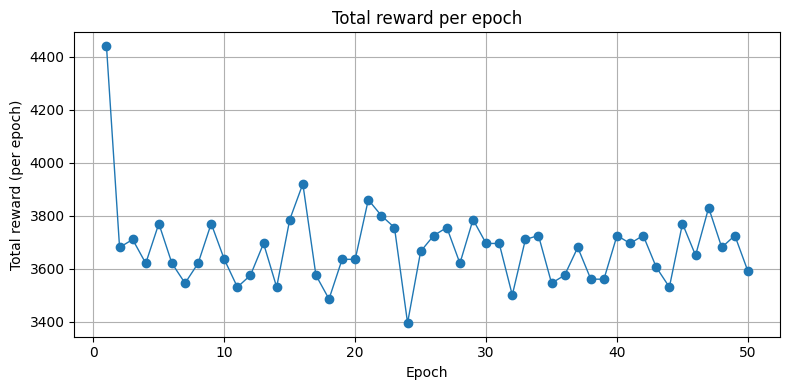

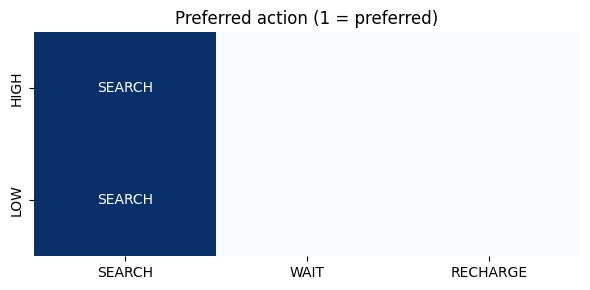


Saved epoch rewards to rewards.txt


In [ ]:
# Train with policy-iteration-like loop and plot rewards + policy heatmap
env = RecyclingRobot(alpha_prob=0.9, beta_prob=0.3, r_search=5.0, r_wait=1.0, r_rescue=-10.0)
learning_rate = 0.1
discount_factor = 0.9
epoch_steps = 1000
n_epochs = 50

# initial policy: search when HIGH, recharge when LOW (conservative starting point)
init_policy = {State.HIGH: Action.SEARCH, State.LOW: Action.RECHARGE}
V_final, learned_policy, rewards = train_policy_iteration(env, init_policy, discount_factor, learning_rate, epoch_steps, n_epochs, rewards_file='rewards.txt')

print('\nFinal value estimates:')
for s, v in V_final.items():
    print(f'  V({s.name}) = {v:.2f}')

print('\nLearned policy:')
for s, a in learned_policy.items():
    print(f'  pi({s.name}) = {a.name}')

# plot rewards
plot_rewards(rewards)
plt.show()

# derive action probabilities from V and plot heatmap
# Choose one of the modes: 'softmax', 'epsilon_greedy', or 'deterministic'
probs = policy_action_probabilities_from_V(
    env,
    V_final,
    discount_factor,
    mode='softmax',        # change to 'epsilon_greedy' or 'deterministic' if desired
    temperature=1.0,       # lower temperature -> more peaky probabilities
    epsilon=0.1            # only used for epsilon_greedy
)

plot_policy_heatmap(
    learned_policy,
    env,
    probs=probs,
    title='Action selection probabilities (derived from V)'
)
plt.show()

print('\nSaved epoch rewards to rewards.txt')
